# **Projet 7 :** Implémentez un modèle de scoring

## Notebook de test pour le dashboard

### Import

In [1]:
import os

# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.1.1


In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


### Configuration

In [3]:
%load_ext autoreload
%autoreload 2

# configurations pandas
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

import warnings
warnings.filterwarnings("ignore")

### Chargement des données

In [4]:
path = './data'
filename = 'Home_Credit_Default_Risk.csv'
data = pd.read_csv(os.path.join(path, filename))
data.set_index('SK_ID_CURR', inplace=True)
print(data.shape)

(356255, 424)


### Selection des stats générales

In [73]:
from sklearn.cluster import MiniBatchKMeans
df = data[['AMT_CREDIT', 'AMT_ANNUITY']].copy()
df = df.fillna(df.mean())
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0)
df['CLUSTER'] = kmeans.fit_predict(df.values)
reduced_df = pd.DataFrame(kmeans.cluster_centers_, columns=['CENTROID_X', 'CENTROID_Y'], index=range(1000))
reduced_df['COUNT'] = df.groupby(['CLUSTER'])['CLUSTER'].count()
reduced_df['COUNT'].fillna(0, inplace=True)

In [92]:
data.set_index('SK_ID_CURR', inplace=True)

In [95]:
data.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse_partner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary_secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single_not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House_apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,...,PREV_NAME_GOODS_CATEGORY_Medicine_MEAN,PREV_NAME_GOODS_CATEGORY_Mobile_MEAN,PREV_NAME_GOODS_CATEGORY_Office_Appliances_MEAN,PREV_NAME_GOODS_CATEGORY_Other_MEAN,PREV_NAME_GOODS_CATEGORY_Photo_Cinema_Equipment_MEAN,PREV_NAME_GOODS_CATEGORY_Sport_and_Leisure_MEAN,PREV_NAME_GOODS_CATEGORY_Tourism_MEAN,PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN,PREV_NAME_GOODS_CATEGORY_Weapon_MEAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,PREV_NAME_PORTFOLIO_Cards_MEAN,PREV_NAME_PORTFOLIO_Cars_MEAN,PREV_NAME_PORTFOLIO_Cash_MEAN,PREV_NAME_PORTFOLIO_POS_MEAN,PREV_NAME_PORTFOLIO_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_XNA_MEAN,PREV_NAME_PRODUCT_TYPE_walk_in_MEAN,PREV_NAME_PRODUCT_TYPE_x_sell_MEAN,PREV_CHANNEL_TYPE_AP_Cash_loan__MEAN,PREV_CHANNEL_TYPE_Car_dealer_MEAN,PREV_CHANNEL_TYPE_Channel_of_corporate_sales_MEAN,PREV_CHANNEL_TYPE_Contact_center

In [86]:
reduced_df['SQRT_COUNT'] = np.sqrt(np.sqrt(reduced_df['COUNT']))

<AxesSubplot:xlabel='CENTROID_X', ylabel='CENTROID_Y'>

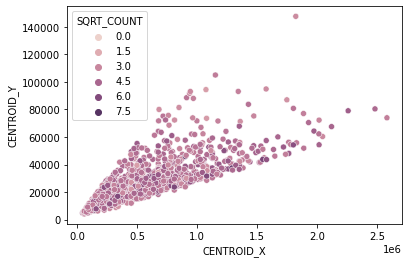

In [90]:
sns.scatterplot(x='CENTROID_X', y='CENTROID_Y', data=reduced_df,  hue='SQRT_COUNT')

In [87]:
reduced_df['SQRT_COUNT'].describe()

count    1000.000000
mean        4.071633
std         0.880822
min         0.000000
25%         3.534119
50%         4.077779
75%         4.575414
max         8.965509
Name: SQRT_COUNT, dtype: float64

### Entrainement du modèle et sauvegarde

In [140]:
from lightgbm import LGBMClassifier
model = LGBMClassifier(
    objective='binary',
    n_jobs=8,
    verbose=-1,
    force_row_wise=True,
    is_unbalance=True,  # try to Automatically balance the weight of the dominated labels
    num_leaves=16,  # Shall be smaller than 2^(max_depth)
    max_depth=8,
    min_child_samples=1000,
    learning_rate=0.1,
    colsample_bytree=0.5,  # Alias for feature_fraction
)
train_data = data[data['TARGET'].notnull()]
feats = [f for f in data.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]
model.fit(
    train_data[feats],
    train_data['TARGET'],
    eval_set=[(train_data[feats], train_data['TARGET'])],
    eval_metric='auc',
    early_stopping_rounds=10
)

[1]	valid_0's auc: 0.643478	valid_0's binary_logloss: 0.287705
[2]	valid_0's auc: 0.66903	valid_0's binary_logloss: 0.305735
[3]	valid_0's auc: 0.706016	valid_0's binary_logloss: 0.323293
[4]	valid_0's auc: 0.717213	valid_0's binary_logloss: 0.341972
[5]	valid_0's auc: 0.72078	valid_0's binary_logloss: 0.362297
[6]	valid_0's auc: 0.724554	valid_0's binary_logloss: 0.38036
[7]	valid_0's auc: 0.727873	valid_0's binary_logloss: 0.398921
[8]	valid_0's auc: 0.729819	valid_0's binary_logloss: 0.416262
[9]	valid_0's auc: 0.732085	valid_0's binary_logloss: 0.432475
[10]	valid_0's auc: 0.733841	valid_0's binary_logloss: 0.44645
[11]	valid_0's auc: 0.735278	valid_0's binary_logloss: 0.460648


LGBMClassifier(colsample_bytree=0.5, force_row_wise=True, is_unbalance=True,
               max_depth=8, min_child_samples=1000, n_jobs=8, num_leaves=16,
               objective='binary', verbose=-1)

In [142]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [151]:
from sklearn.model_selection import cross_val_score, cross_validate
res = cross_validate(model, train_data[feats], train_data['TARGET'], cv=5, scoring=ftwo_scorer, verbose=2, return_train_score=True, return_estimator=True, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  1.1min finished


In [171]:
from sklearn.metrics import roc_auc_score
model.fit(
    train_data[feats],
    train_data['TARGET'],
    eval_set=[(train_data[feats], train_data['TARGET'])],
    eval_metric='auc'
)
predproba = model.predict_proba(train_data[feats])
predprobapos = predproba[:,1]
print("Proba:", predprobapos)
auc_score = roc_auc_score(train_data['TARGET'], predprobapos)
print("AUC:", auc_score)

AttributeError: 'numpy.ndarray' object has no attribute 'predict'

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called the Specificity.
- Sensitivity = TruePositive / (TruePositive + FalseNegative)
- Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:
- Sensitivity = True Positive Rate
- Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

- G-Mean = sqrt(Sensitivity * Specificity)

In [6]:
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
import numpy as np

model = LGBMClassifier(
        objective='binary',
        n_jobs=8,
        verbose=0,
        force_row_wise=True,
        is_unbalance=True,
        num_leaves=16,
        max_depth=8,
        min_child_samples=1000,
        learning_rate=0.1,
        colsample_bytree=0.5,
)

train_data = data[data['TARGET'].notnull()]
feats = [f for f in data.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

n_folds = 5
folds = StratifiedKFold(n_splits=n_folds, random_state=None, shuffle=False)
best_thresh = []
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_data[feats], train_data['TARGET'])):
        train_x, train_y = train_data[feats].iloc[train_idx], train_data['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_data[feats].iloc[valid_idx], train_data['TARGET'].iloc[valid_idx]

        model.fit(
                train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc',
                verbose= False
        )

        yhat = model.predict_proba(valid_x)
        yhat = yhat[:, 1]
        fpr, tpr, thresholds = roc_curve(valid_y, yhat)
        J = tpr - fpr
        ix = np.argmax(J)
        best_thresh.append(thresholds[ix])
        print('Best Threshold=%f' % (thresholds[ix]))

mean_thres = np.mean(best_thresh)
print('Mean Threshold=%f' % (mean_thres))

Best Threshold=0.510971
Best Threshold=0.497814
Best Threshold=0.484681
Best Threshold=0.482688
Best Threshold=0.471238
Mean Threshold=0.489478


In [5]:
from src.model.app import ModelApp
model_app = ModelApp(data)
model_app.fit_model()
model_app.refine_threshold()
model_app.make_data_for_graph1()
model_app.make_explanation()

[10]	valid_0's auc: 0.733841	valid_0's binary_logloss: 0.44645
[20]	valid_0's auc: 0.744397	valid_0's binary_logloss: 0.542374
[30]	valid_0's auc: 0.751733	valid_0's binary_logloss: 0.575639
[40]	valid_0's auc: 0.756501	valid_0's binary_logloss: 0.585061
[50]	valid_0's auc: 0.761805	valid_0's binary_logloss: 0.58512
[60]	valid_0's auc: 0.765452	valid_0's binary_logloss: 0.583023
[70]	valid_0's auc: 0.76921	valid_0's binary_logloss: 0.579611
[80]	valid_0's auc: 0.772142	valid_0's binary_logloss: 0.576764
[90]	valid_0's auc: 0.774645	valid_0's binary_logloss: 0.574257
[100]	valid_0's auc: 0.77701	valid_0's binary_logloss: 0.571997
[10]	training's auc: 0.729642	training's binary_logloss: 0.444959	valid_1's auc: 0.721215	valid_1's binary_logloss: 0.446202
[20]	training's auc: 0.744676	training's binary_logloss: 0.539621	valid_1's auc: 0.73526	valid_1's binary_logloss: 0.541495
[30]	training's auc: 0.751574	training's binary_logloss: 0.574379	valid_1's auc: 0.740483	valid_1's binary_logloss

In [282]:
import shap
explainer = shap.TreeExplainer(model_app.model)
shap_values = explainer.shap_values(model_app.data.loc[[100001], model_app.feats])

In [24]:
sv = np.array(shap_values)
y = model_app.model.predict(model_app.data[model_app.feats]).astype("bool")
sv_positive = sv[:,y,:]
sv_negative = sv[:,~y,:]
sv.shape

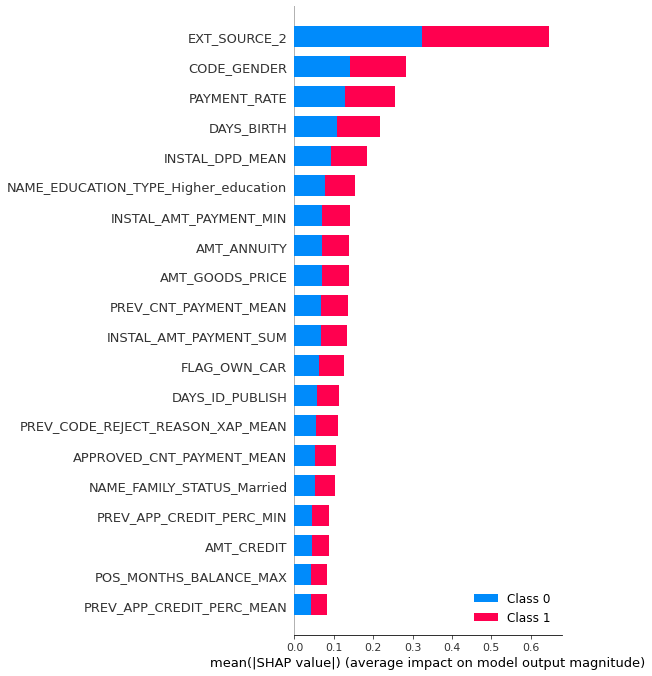

In [37]:
shap.summary_plot(shap_values, model_app.data[model_app.feats], plot_type="bar")

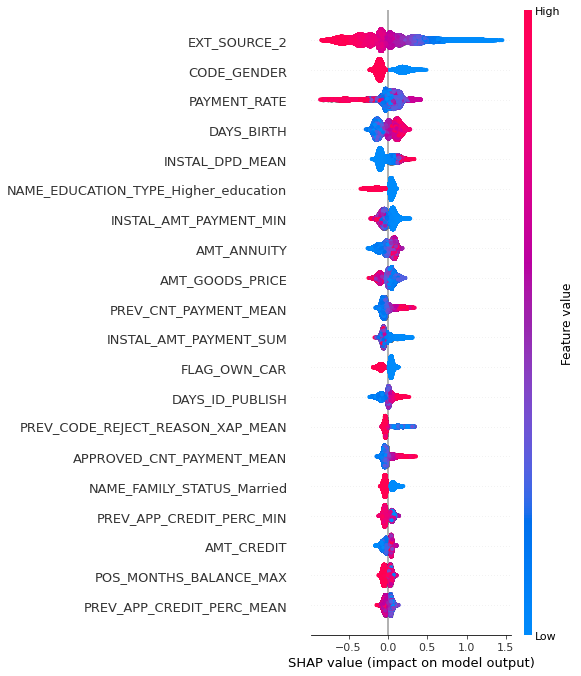

In [107]:
shap.summary_plot(shap_values[1], model_app.data[model_app.feats].astype("float"), show=False)

In [29]:
credit_id = 100001
explainer = model_app.shap_explainer
shap_values = explainer.shap_values(model_app.data.loc[[credit_id], model_app.feats])
credit = pd.Series(shap_values[1][0], index=model_app.feats)

In [1]:
sv_df = pd.DataFrame(shap_values[1], columns=model_app.feats, index=model_app.data.index)
sv_df.head()

NameError: name 'pd' is not defined

In [146]:
sv_df_agg = sv_df.describe(percentiles=[0.25, 0.5, 0.75]).transpose()
sv_df_agg['dist'] = np.abs(sv_df_agg['max'] - sv_df_agg['min'])
sv_df_agg['feature_importance'] = model_app.model.feature_importances_
sv_df_agg.sort_values('feature_importance', ascending=False, inplace=True)

In [150]:
main_features = sv_df_agg.index[:10].tolist()
sv_df_agg.loc[main_features]

,count,mean,std,min,25%,50%,75%,max,dist,feature_importance
PAYMENT_RATE,356255.0,-0.007754,0.190161,-0.861338,-0.044954,0.023255,0.105729,0.420928,1.282265,102
EXT_SOURCE_2,356255.0,-0.002923,0.408954,-0.845133,-0.307973,-0.058455,0.256398,1.454920,2.300053,74
DAYS_BIRTH,356255.0,-0.000313,0.123059,-0.281116,-0.118871,0.006184,0.112058,0.283793,0.564909,42
INSTAL_DPD_MEAN,356255.0,-0.005583,0.101991,-0.204623,-0.097663,-0.024921,0.084201,0.335946,0.540569,38
APPROVED_CNT_PAYMENT_MEAN,356255.0,-0.003097,0.067594,-0.144621,-0.045919,-0.026523,0.022970,0.357896,0.502517,37
AMT_ANNUITY,356255.0,0.004953,0.081614,-0.257712,-0.050858,0.016581,0.073862,0.185988,0.443700,37
PREV_CNT_PAYMENT_MEAN,356255.0,0.000304,0.086600,-0.160040,-0.059864,-0.033010,0.032568,0.341162,0.501202,36
INSTAL_AMT_PAYMENT_SUM,356255.0,-0.001589,0.082253,-0.169925,-0.059641,-0.032629,0.033798,0.313014,0.482939,35
DAYS_ID_PUBLISH,356255.0,-0.001078,0.072059,-0.235080,-0.063762,0.010364,0.042149,0.271771,0.506851,33
AMT_CREDIT,356255.0,-0.009533,0.048841,-0.161196,-0.048644,-0.015892,0.038351,0.110438,0.271634,31


In [44]:
import plotly.graph_objects as go
main_features = model_app.shap_data_desc[1].index[:10].tolist()
main_features.reverse()
fig = go.Figure()
for i, c in enumerate(main_features):
    fig.add_trace(go.Box(
        y0=c,
        x=[[0]],
        pointpos=0,
        q1=model_app.shap_data_desc[1].loc[[c], '25%'],
        median=model_app.shap_data_desc[1].loc[[c], '50%'],
        q3=model_app.shap_data_desc[1].loc[[c], '75%'],
        lowerfence=model_app.shap_data_desc[1].loc[[c], 'min'],
        upperfence=model_app.shap_data_desc[1].loc[[c], 'max'],
        mean=model_app.shap_data_desc[1].loc[[c], 'mean'],
        marker_color='indianred',
        line_color=f'hsl(224, 50, {60-4*i})',
        name=c,
        hoverinfo='x')
    )
fig.show()

In [100]:
fi = pd.Series(model_app.feature_importances).to_frame(name='feature_importance')
fi

,feature_importance
PAYMENT_RATE,102
EXT_SOURCE_2,74
DAYS_BIRTH,42
INSTAL_DPD_MEAN,38
APPROVED_CNT_PAYMENT_MEAN,37
...,...
ORGANIZATION_TYPE_Industry_type_13,0
PREV_CODE_REJECT_REASON_CLIENT_MEAN,0
ORGANIZATION_TYPE_Industry_type_12,0
ORGANIZATION_TYPE_Industry_type_11,0


In [115]:
import plotly.express as px
fi = pd.concat([
    pd.Series(model_app.feature_importances).to_frame(name='feature_importances'),
    model_app.data.loc[100001, model_app.feats].T.to_frame(name="credit")
], axis=1)
fig = px.bar(
    fi.sort_values('feature_importances')[-20:],
    x='feature_importances',
    color='feature_importances',
    color_continuous_scale='Viridis',
    hover_data=['credit']
)
fig.show()

In [ ]:
px.scatter

In [147]:
from src.dashboard.utils import get_credit_stats, get_graph_1, get_credit_by_id, get_graph_2, get_features
res = get_features(features="AMT_CREDIT,AMT_ANNUITY", limit=1000)

In [150]:
pd.DataFrame(res['features'])

,AMT_CREDIT,AMT_ANNUITY,proba,score
389360,152820.0,15241.5,0.194487,80.133221
364179,414792.0,21847.5,0.733857,25.036791
185467,450000.0,27531.0,0.334116,65.870174
195506,1057266.0,47295.0,0.348395,64.411652
413527,675000.0,21906.0,0.394399,59.712290
...,...,...,...,...
363408,1341490.5,44464.5,0.259599,73.482123
119115,220536.0,9400.5,0.343554,64.906116
252684,225000.0,17905.5,0.871374,10.989585
268614,584766.0,28260.0,0.796325,18.655789


In [130]:
df = model_app.data.sample(100)

In [140]:
proba = model_app.model.predict_proba(df[model_app.feats])


In [141]:
df['proba'] = proba[:, 1]

In [144]:
df['score'] = (1 - (df['proba'] * 0.5 / model_app.threshold))*100

In [159]:
_df = model_app.data.loc[100001, ['AMT_CREDIT', 'AMT_ANNUITY']]

In [168]:
fig = px.scatter(df, x='AMT_CREDIT', y='AMT_ANNUITY', color='score', hover_data=['AMT_CREDIT', 'AMT_ANNUITY', 'score'], color_continuous_scale='viridis')
fig.add_trace(go.Scatter(x=[_df['AMT_CREDIT']], y=[_df['AMT_ANNUITY']], mode='markers', showlegend=False, marker={'size':10}))
fig.show()